## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
from thunder.images import fromtif, frombinary
from showit import image

In [4]:
from skimage.io import imsave, imread

In [5]:
from mesoscope.models import compare, overlay, filter_shape

In [6]:
from mesoscope.traces import dff

## Set directory and session information

In [7]:
directory = '/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00'
data = fromtif(directory + '/images', ext='tiff', engine=sc)

In [82]:
directory = '/groups/freeman/freemanlab/neurofinder/01.00'
data = frombinary(directory + '/images', recursive=True, engine=sc, order='F')

In [8]:
data

Images
mode: spark
dtype: uint16
shape: (8000, 512, 512)

In [9]:
data = data[:2000,:,:]

In [10]:
mean = data.mean().toarray()

In [11]:
from extraction import load
modelCompare = load('/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00/regions/regions3.json')

In [87]:
from json import load
with open(directory +'/sources/sources.json', 'r') as f:
    raw = load(f)
    modelCompare = ExtractionModel([x['coordinates'] for x in raw])

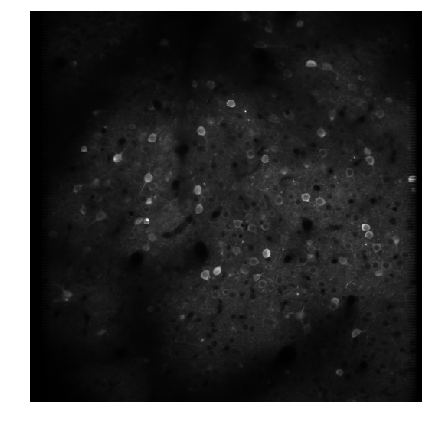

In [12]:
image(mean);

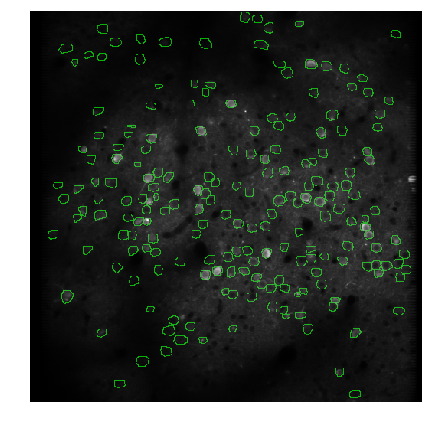

In [13]:
blend = overlay(modelCompare, image=mean)
image(blend);

### Extraction

In [18]:
from extraction import NMF

In [19]:
diameter = 11
algorithm = NMF(k=10, percentile=99, max_iter=50, overlap=0.1)
unmerged = algorithm.fit(data, chunk_size=(50,50), padding=(25,25))
model = unmerged.merge(0.1)
model = filter_shape(model, min_diameter = 0.7*diameter, max_diameter = 1.3*diameter, min_eccentricity = 0.2)

In [21]:
compare(model, modelCompare, threshold=5)

{'combined': 0.56329113924050633,
 'count': 119,
 'exclusion': 0.75924294615085175,
 'inclusion': 0.8133456110114029,
 'precision': 0.74789915966386555,
 'recall': 0.45177664974619292,
 'threshold': 5}

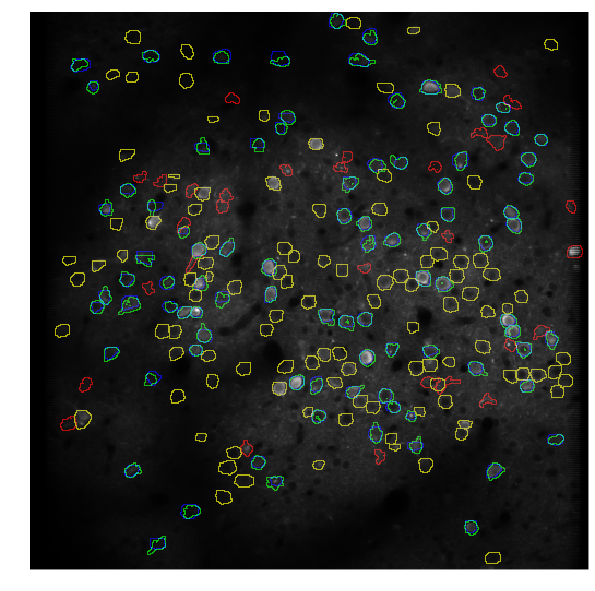

In [22]:
blend = overlay(model, image=mean, compare=modelCompare, threshold=5)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [23]:
#model.save('/tier2/freeman/Nick/neurofinder/neurofinder.02.00/regions/regions-nmf.json')

## Region morph.

In [24]:
#### add closing etc. to regional         !!!!!!!!!!!
#### add region_props getting to regional !!!!!!!!!!!
#### add filter_shape to ExtractionModel !!!!!!!!!!!!
#### make ExtractionModel load able to handle just coordinates !!!!!!!!!!!!

In [25]:
from regional import one
from numpy import zeros, ones

In [26]:
def fill(self):
    """
    Fill a region using morphological operators.
    """
    from scipy.ndimage.morphology import binary_fill_holes
    coords = self.coordinates
    tmp = zeros(self.extent)
    coords = (coords - self.bbox[0:len(self.center)])
    tmp[coords.T.tolist()] = 1
    tmp = binary_fill_holes(tmp)
    new = asarray(where(tmp)).T + self.bbox[0:len(self.center)]
    new = [c for c in new if all(c >= 0)]

    return one(new)

In [27]:
def erosion(self, size):
    """
    Erode a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of erosion in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_erosion
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_erosion(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [28]:
def closing(self, size):
    """
    Close a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of closing in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_closing
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_closing(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [29]:
def opening(self, size):
    """
    Open a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of opening in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_opening
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_opening(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

In [30]:
def dilate(self, size):
    """
    Dilate a region using morphological operators.
    Parameters
    ----------
    size : int
        Size of dilation in pixels
    """
    if size > 0:
        from scipy.ndimage.morphology import binary_dilation
        size = (size * 2) + 1
        coords = self.coordinates
        tmp = zeros(self.extent + size * 2)
        coords = (coords - self.bbox[0:len(self.center)] + size)
        tmp[coords.T.tolist()] = 1
        tmp = binary_dilation(tmp, ones((size, size)))
        new = asarray(where(tmp)).T + self.bbox[0:len(self.center)] - size
        new = [c for c in new if all(c >= 0)]
    else:
        return self

    return one(new)

## Center window extraction

In [14]:
from mesoscope.CC import CC

In [15]:
diameter = 11
algorithm = CC(diameter=diameter, clip_limit=0.04, theshold=0.2, sigma_blur=3, boundary=(30,15))
unmerged = algorithm.fit(data)

/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [16]:
model = unmerged.merge(overlap=0.20, max_iter=3, k_nearest=10)
model = filter_shape(model, min_diameter = 0.7*diameter, max_diameter = 1.3*diameter, min_eccentricity = 0.2)

In [17]:
compare(model, modelCompare, threshold=5)

{'combined': 0.62538699690402466,
 'count': 126,
 'exclusion': 0.88430413324705004,
 'inclusion': 0.79127210856179642,
 'precision': 0.80158730158730163,
 'recall': 0.51269035532994922,
 'threshold': 5}

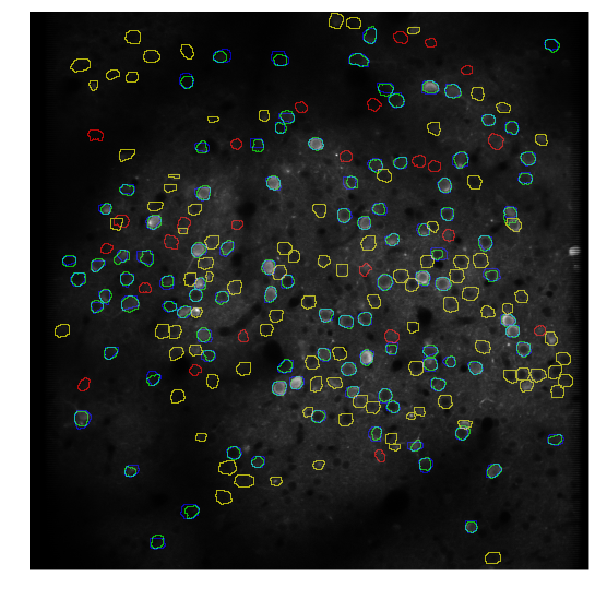

In [18]:
blend = overlay(model, image=mean, compare=modelCompare, threshold=5, correct=False)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [19]:
#model.save('/tier2/freeman/Nick/neurofinder/neurofinder.02.00/regions/regions-gtBoundary.json')

## Traces

In [20]:
traces = dff(data, model)

In [21]:
#t.tobinary()

In [22]:
t = traces.toarray()

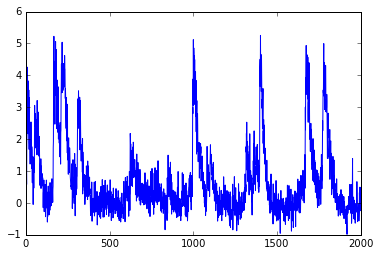

In [23]:
plt.plot(t[0]);